In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error,log_loss
from sklearn.model_selection import KFold
import lightgbm as lgb
from tqdm import tqdm_notebook
import geopandas as gpd

import warnings
warnings.filterwarnings("ignore")
import math

In [2]:
DATA_FOLDER = './input_files/'
OUTPUT_PATH = './output_files/model_3_withoutexternal.csv'
df = pd.read_csv(DATA_FOLDER + "Train.csv")
sub_df = pd.read_csv(DATA_FOLDER + "SampleSubmission.csv")
wetlands = pd.read_csv(DATA_FOLDER + 'wetlands.csv')

In [3]:
precip_cols = [c for c in df.columns if 'precip' in c]
len(precip_cols), len(precip_cols)//2

(34, 17)

In [4]:
precip_cols_2015 = precip_cols[0: 17]
precip_cols_2019 = precip_cols[17: 34]
train = df[precip_cols_2015]
train.columns = [f'precip_week_{i}' for i in range(1, 18)]
test = df[precip_cols_2019]
test.columns = [f'precip_week_{i}' for i in range(1, 18)]
train = pd.concat([train, df[['X', 'Y', 'target_2015', 'elevation', 'LC_Type1_mode', 'Square_ID']]], axis=1)
test = pd.concat([test, df[['X', 'Y', 'target_2015', 'elevation', 'LC_Type1_mode', 'Square_ID']]], axis=1)

In [5]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.X, df.Y))

In [6]:
df = pd.concat([train, test]).reset_index(drop=True)
df.shape

(32932, 23)

In [7]:
precip_cols = [c for c in df.columns if 'precip' in c]
len(precip_cols)
print(precip_cols)

['precip_week_1', 'precip_week_2', 'precip_week_3', 'precip_week_4', 'precip_week_5', 'precip_week_6', 'precip_week_7', 'precip_week_8', 'precip_week_9', 'precip_week_10', 'precip_week_11', 'precip_week_12', 'precip_week_13', 'precip_week_14', 'precip_week_15', 'precip_week_16', 'precip_week_17']


In [8]:
def add_diff_interacts(df, inter_cols):
    '''
    This function calucates all possible combinations of differences for columns provided to into pairs for the given dataframe.
    For example: If we have columns: Col_1, Col_2, Col_3 then it will calculate Col_1 - Col_2, Col_1 - Col_3, Col_2 - Col_3
    This is to calculate the differnce in precipitation between different weeks of rainfall, like the difference in rainfall between week 17 and week 16.
    
    df: DataFrame
    inter_cols: The columns for which the difference needs to be computed
    
    returns: New dataframe with the difference columns added to it.
    '''
    def apply_interacts(x, inter_cols):
        cols = [x + '_diff_' + c for c in inter_cols[inter_cols.index(x)+1:]]
        interacts_df[cols] = pd.concat([df[x] - df[c] for c in inter_cols[inter_cols.index(x)+1:]], axis=1)
    
    interacts_df = pd.DataFrame()
    _ = df[inter_cols[:-1]].apply(lambda x: apply_interacts(x.name, inter_cols))
    df = pd.concat([df, interacts_df], axis=1)

    return df
df = add_diff_interacts(df, precip_cols)

step = 0.2
to_bin = lambda x: np.floor(x / step) * step
df["latbin"] = df.X.map(to_bin)
df["lonbin"] = df.Y.map(to_bin)

df['prev_x'] = df['X'] - 0.01
df['next_x'] = df['X'] + 0.01
df['prev_y'] = df['Y'] - 0.01
df['next_y'] = df['Y'] + 0.01

In [9]:
def cart2rho(x, y):
    rho = np.sqrt(x**2 + y**2)
    return rho


def cart2phi(x, y):
    phi = np.arctan2(y, x)
    return phi


def operating_with_coordinates(tr_df, te_df):
    for df in [tr_df, te_df]:
        # apply the polar coordinates system
        df["num_rho"] = df.apply(lambda x: cart2rho(x["X"] - 35.12, x["Y"]+15.82), axis=1)
        df["num_phi"] = df.apply(lambda x: cart2phi(x["X"] - 35.12, x["Y"]+15.82), axis=1)
    return tr_df, te_df

In [10]:
train = df[:train.shape[0]].reset_index(drop=True)
test = df[train.shape[0]:].reset_index(drop=True)
features = [c for c in train.columns if c not in ['Square_ID','target_2015', 'geometry'] + precip_cols]

In [11]:
train,test=operating_with_coordinates(train,test)

In [12]:
rotation_cols = [c for c in train.columns if 'num_rot' in c]
features = [c for c in train.columns if c not in ['Square_ID','target_2015', 'geometry'] + precip_cols + rotation_cols]

In [13]:
param = {'num_leaves': 186,
     'min_data_in_leaf': 40, 
     'objective':'regression',
     'max_depth': 18,
     'learning_rate': 0.1,
     "boosting": "gbdt",
     "feature_fraction": 0.8,
     "metric": 'rmse',
     "lambda_l1": 0,
     "lambda_l2": 0.1,
    }


target = train['target_2015']

folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))
feature_importance_df = pd.DataFrame()



#### Our chosen hyperparameters were under-predicting the floods in some sense, the maximum flooding was around 0.8xx
#### To remedy this underprediction we chose an arbitary number greater than one, i.e, 1.08, so our maximum flooding crossed 0.9
#### Choosing a multiplier only changes the non-zero values.
#### The '0' values or areas with no flood will not be affected as 0 x 1.08 = 0 still.

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx]*1.08)
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx]*1.08)

    num_round = 1500
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 200)
    oof_lgb[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    curr_preds = clf.predict(test[features], num_iteration=clf.best_iteration)
    curr_preds[curr_preds < 0.2] = 0
    curr_preds[curr_preds > 1] = 1
    print(pd.Series(curr_preds).describe())
    predictions_lgb += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

oof_lgb[oof_lgb < 0] = 0
print("CV score: {:<8.5f}".format(mean_squared_error(oof_lgb, target)**0.5))
#     preds_df[mult] = predictions_lgb
pt_1 = predictions_lgb

fold n°0
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 0.0830385	valid_1's rmse: 0.10379
[200]	training's rmse: 0.0720546	valid_1's rmse: 0.100299
[300]	training's rmse: 0.0664536	valid_1's rmse: 0.0988795
[400]	training's rmse: 0.0617854	valid_1's rmse: 0.0978769
[500]	training's rmse: 0.0585365	valid_1's rmse: 0.0973809
[600]	training's rmse: 0.0552914	valid_1's rmse: 0.097191
[700]	training's rmse: 0.0528525	valid_1's rmse: 0.0969422
[800]	training's rmse: 0.0506333	valid_1's rmse: 0.0968877
[900]	training's rmse: 0.0487459	valid_1's rmse: 0.0969237
Early stopping, best iteration is:
[764]	training's rmse: 0.0513792	valid_1's rmse: 0.0968748
count    16466.000000
mean         0.025145
std          0.118364
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          0.869717
dtype: float64
fold n°1
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 0.0823515	valid_1's r

In [14]:
pt_1[pt_1 < 0.2] = 0
pt_1[pt_1 > 1] = 1

In [15]:
features = [c for c in train.columns if c not in ['Square_ID','target_2015', 'geometry'] + precip_cols + rotation_cols + ['num_rho','num_phi']]
print(len(features))
all_test_preds_df = pd.DataFrame()
param = {'num_leaves': 186,
     'min_data_in_leaf': 40, 
     'objective':'regression',
     'max_depth': 18,
     'learning_rate': 0.1,
     "boosting": "gbdt",
     "feature_fraction": 0.8,
     "metric": 'rmse',
     "lambda_l1": 0,
     "lambda_l2": 0.1,
    }


target = train['target_2015']

folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))
feature_importance_df = pd.DataFrame()


#### Our chosen hyperparameters were under-predicting the floods in some sense, the maximum flooding was around 0.8xx
#### To remedy this underprediction we chose an arbitary number greater than one, i.e, 1.08, so our maximum flooding crossed 0.9
#### Choosing a multiplier only changes the non-zero values.
#### The '0' values or areas with no flood will not be affected as 0 x 1.08 = 0 still.

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx]*1.08)
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx]*1.08)

    num_round = 1500
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 200)
    oof_lgb[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    predictions_lgb += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

oof_lgb[oof_lgb < 0] = 0
print("CV score: {:<8.5f}".format(mean_squared_error(oof_lgb, target)**0.5))
pt_2 = predictions_lgb


146
fold n°0
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 0.0870207	valid_1's rmse: 0.107534
[200]	training's rmse: 0.0786058	valid_1's rmse: 0.105295
[300]	training's rmse: 0.0735251	valid_1's rmse: 0.104011
[400]	training's rmse: 0.0693709	valid_1's rmse: 0.103302
[500]	training's rmse: 0.0658148	valid_1's rmse: 0.102391
[600]	training's rmse: 0.0633515	valid_1's rmse: 0.102048
[700]	training's rmse: 0.0607474	valid_1's rmse: 0.101767
[800]	training's rmse: 0.0585479	valid_1's rmse: 0.101763
[900]	training's rmse: 0.0566462	valid_1's rmse: 0.101536
[1000]	training's rmse: 0.0550786	valid_1's rmse: 0.101504
[1100]	training's rmse: 0.053607	valid_1's rmse: 0.101366
[1200]	training's rmse: 0.0521633	valid_1's rmse: 0.101392
[1300]	training's rmse: 0.0508622	valid_1's rmse: 0.101331
[1400]	training's rmse: 0.0498141	valid_1's rmse: 0.101231
[1500]	training's rmse: 0.0487748	valid_1's rmse: 0.101147
Did not meet early stopping. Best iteration is:
[

In [16]:
pt_2[pt_2 < 0.2] = 0
pt_2[pt_2 > 1] = 1

In [17]:
predictions_lgb = pt_1 * 0.7 + pt_2 * 0.3

In [18]:
def rectify_submission(best_sub):
    '''
    This function is used to rectify the submissions based on EDA, and external data. 
    The documentation for the function can be found at: " "
    wetlands: Gives the wetland distance of the place. The data source used is " ", and is described at: " "
    
    '''
    
    train['wetland_dist'] = wetlands['wetland_dist']
    target = train['target_2015']
    gdf = gpd.GeoDataFrame(
        train, geometry=gpd.points_from_xy(train.X, train.Y))
    gdf['target_2015'] = target
    gdf['best_sub'] =  best_sub
    
    best_sub_2 = best_sub.copy()
    
    #### Rectifications based on wetland distance. Places very near the wetlands are more likely to get flooded and vice versa.
    #### The magnitues are in metres, So 5000 metres = 5 kilometres and 10000 metres = 10 kilometres
    sel = (best_sub_2 == 0)
    best_sub_2[sel] = 0.03
    sel = (train['wetland_dist'] > 5000) & (train['wetland_dist'] <= 10000)
    best_sub_2[sel] = 0.015
    sel = (train['wetland_dist'] > 10000)
    best_sub_2[sel] = 0
    sel = (train['wetland_dist'] == 0) & (train['target_2015'] == 1) & (train['elevation'] < 55)
    best_sub_2[sel] = 0.94
    
    ### These regions have very low elevation, and the predictions is quite high for them, so we make it even higher
    sel = (train['elevation'] < 100) & (best_sub_2 > 0.85)
    best_sub_2[sel] = 0.95
    
    #### These regions are neither unflooded nor too much flooded, we blend them with the floods of 2015, by a very small amount to get a small boost
    sel = (best_sub_2 > 0.1) & (best_sub_2 < 0.9)
    best_sub_2[sel] = best_sub_2[sel] * 0.85 + train['target_2015'][sel] * 0.15
    
    
    ### The lower part of the map is mostly flooded, so we increase the flooding of the unflooded regions by a small percen (5 %).
    ### This is again an arbitary number, and can further be tuned further
    sel = (best_sub_2 > 0) & (best_sub_2 < 0.03) & (train.Y < 16.0)
    print(sel.sum())
    best_sub_2[sel] *= 1.05
    
    ### The eastern hemisphere is almost completely not flooded in our 2019 predictions, and we only see a negligibly small spot flooded.
    ### To get rid of it, we set the flooding of the entire eastern region to 0.
    gdf['rectified'] = best_sub_2
    sel = (train.X >= 35.3) & (train.Y <= 15.9)
    gdf.loc[sel, 'rectified'] = 0.00
    return gdf['rectified']

In [19]:
predictions_lgb = rectify_submission(predictions_lgb)

3285


In [20]:
SUB_FILE_NAME = OUTPUT_PATH
sub=test[["Square_ID"]]
sub['target_2019'] = predictions_lgb
sub.to_csv(SUB_FILE_NAME, index = False)
sub['target_2019'].describe()

count    16466.000000
mean         0.034141
std          0.137324
min          0.000000
25%          0.000000
50%          0.000000
75%          0.015750
max          0.950000
Name: target_2019, dtype: float64

In [21]:
from IPython.display import HTML
def create_download_link(title = "Download CSV file", filename = "data.csv"):  
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)
create_download_link(filename = SUB_FILE_NAME)

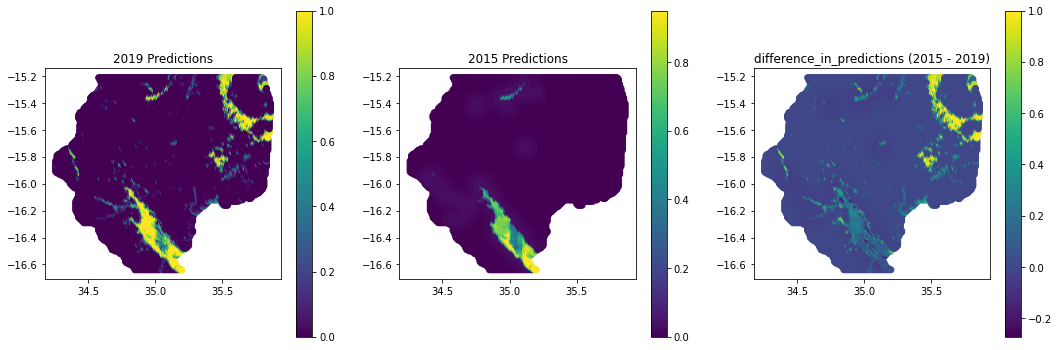

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
gdf['target_2019'] = predictions_lgb
gdf['target_2015'] = target
gdf['difference_in_predictions (2015 - 2019)'] = gdf['target_2015'] - gdf['target_2019']
gdf.plot(column = 'target_2015', figsize=(6, 6), legend=True, ax = axes[0])
gdf.plot(column = 'target_2019', figsize=(6, 6), legend=True, ax = axes[1])
gdf.plot(column = 'difference_in_predictions (2015 - 2019)', legend=True, ax = axes[2])
_ = axes[0].set_title('2019 Predictions')
_ = axes[1].set_title('2015 Predictions')
_ = axes[2].set_title('difference_in_predictions (2015 - 2019)')

In [23]:
sub['target_2019'].describe()

count    16466.000000
mean         0.034141
std          0.137324
min          0.000000
25%          0.000000
50%          0.000000
75%          0.015750
max          0.950000
Name: target_2019, dtype: float64